# Retrieve spectra using Simple Spectral Access protocol

This notebook is one of a set produced by NAVO to demonstrate data access with python tools. If you have not already, start with the [overview notebook](Workshop.ipynb).

To run all of this notebook, you will also need a build of __[pyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html)__, which is part of __[HEASOFT](https://heasarc.gsfc.nasa.gov/lheasoft/)__. You'll also need the __[wurlitzer](https://github.com/minrk/wurlitzer)__ python package to capture the Xspec output in this notebook. (Note that it is not available via 'conda install wurlitzer" for anaconda 3, but you can 'pip install wurlitzer'.)

Note:  because of the way that pyXspec stores information, re-running the same cells repeatedly often does not work. If you have problems, restart the kernel and run the whole notebook fresh.

In [1]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline  
import requests, io
from astropy.table import Table

import xspec
## For capturing Xspec terminal output
##  See https://github.com/minrk/wurlitzer
from wurlitzer import sys_pipes
## Hide annoying warnings
import warnings
warnings.filterwarnings("ignore")

from navo_utils.spectra import Spectra, SpectraColumn

from astropy.coordinates import SkyCoord


## Find out what catalogs of spectra can be queried with SSA service:

(See the notebook about how to use the [Registry](Registry.ipynb) for information on this sort of query.)

In [2]:
from navo_utils.registry import Registry
services=Registry.query(service_type='spectr',source='heasarc')
services

waveband,short_name,ivoid,res_description,access_url,reference_url,publisher,service_type
str15,str12,str29,str2899,str64,str58,str17,str20
gamma-ray#x-ray,INTEGRAL/BSC,ivo://nasa.heasarc/intbsc,"The INTEGRAL Bright Source Catalog is based on publicly available data from the two main instruments (IBIS and SPI) on board INTEGRAL (see Winkler et al. 2003, A&amp;amp;A, 411, L1 for a description of the INTEGRAL spacecraft and instrument packages). INTEGRAL began collecting data in October 2002. This catalog will be regularly updated as data become public (~14 months after they are obtained). The Bright Source Catalog is a collaborative effort between the INTEGRAL Science Data Center (ISDC) in Switzerland and the NASA Goddard Space Flight Center (GSFC) INTEGRAL Guest Observer Facility (GOF). The results presented here are a result of a semi-automated analysis and they should be considered as approximate: they are intended to serve as a guideline to those interested in pursuing more detailed follow-up analyses. The data from the imager ISGRI (Lebrun et al. 2003, A&amp;amp;A, 411, L141) have been analyzed at the INTEGRAL Science Data Centre (ISDC), while the SPI (Vedrenne et al. 2003, A&amp;amp;A, 411, L63) data analysis was performed at GSFC as a service of the INTEGRAL GOF.",https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=intbsc&amp;,https://heasarc.gsfc.nasa.gov/W3Browse/all/intbsc.html,NASA/GSFC HEASARC,simplespectralaccess
gamma-ray#x-ray,INTEGRAL/BSC,ivo://nasa.heasarc/intbsc,"The INTEGRAL Bright Source Catalog is based on publicly available data from the two main instruments (IBIS and SPI) on board INTEGRAL (see Winkler et al. 2003, A&amp;amp;A, 411, L1 for a description of the INTEGRAL spacecraft and instrument packages). INTEGRAL began collecting data in October 2002. This catalog will be regularly updated as data become public (~14 months after they are obtained). The Bright Source Catalog is a collaborative effort between the INTEGRAL Science Data Center (ISDC) in Switzerland and the NASA Goddard Space Flight Center (GSFC) INTEGRAL Guest Observer Facility (GOF). The results presented here are a result of a semi-automated analysis and they should be considered as approximate: they are intended to serve as a guideline to those interested in pursuing more detailed follow-up analyses. The data from the imager ISGRI (Lebrun et al. 2003, A&amp;amp;A, 411, L141) have been analyzed at the INTEGRAL Science Data Centre (ISDC), while the SPI (Vedrenne et al. 2003, A&amp;amp;A, 411, L63) data analysis was performed at GSFC as a service of the INTEGRAL GOF.",https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=intbsc&amp;,https://heasarc.gsfc.nasa.gov/W3Browse/all/intbsc.html,NASA/GSFC HEASARC,simplespectralaccess
gamma-ray,SwiftBAT,ivo://nasa.heasarc/swiftbalog,"The BAT can operate several configuration modes simultaneously. Each of the simultaneous modes is listed in separate records within this table. For a given time interval, there are several records (partially overlapping in time), each describing a single configuration/mode. The BAT modes collect data for the entire FOV but also have the capability to record rates (tag mask rate) for up to a few specific sky positions (typically 3) that correspond to a pre-assigned target ID. It is possible that at least two or more of these positions do not coincide with the BAT or NFI pointing position and therefore the target ID does necessarily coincide with Target_ID of the BAT or NFI pointing position. This table records for the position (RA and Dec) and Target_ID parameters the correct values associated to each of the mask tag data.",https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=swiftbalog&amp;,https://heasarc.gsfc.nasa.gov/W3Browse/all/swiftbalog.html,NASA/GSFC HEASARC,simplespectralaccess
gamma-ray,SwiftBAT,ivo://nasa.heasarc/swiftbalog,"The BAT can operate several configuration modes simultaneously. Each of the simultaneous modes is listed in separate records within this table. For a 

## Query one of them, in this case Chandra for the source M82:

In [3]:
pos1='148.968458,69.679703' # M82
pos2='83.633083,22.014500' # crab
pos3='191.542417,30.731583' #mice
pos=[pos1,pos2,pos3]
spec_tables=Spectra.query(service=services[-1],coords=pos,radius=0.1,verbose=True)

spec_tables[0]['time'].format='.4f'
## Let's look at the results for M82:
spec_tables[0].show_in_notebook()

    Querying service https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&
    Got 3 results for parameters[0]
    Got 40 results for parameters[1]
    (Got no results for parameters[2])


idx,obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_start_time,SSA_tmid,SSA_stop_time,SSA_duration,SSA_ra,SSA_dec,SSA_coord_obs,SSA_title,SSA_reference,SSA_datalength,SSA_datamodel,SSA_instrument,SSA_publisher,SSA_format,SSA_fov,SSA_wavelength_min,SSA_wavelength_max,SSA_bandwidth,SSA_bandpass
,,,,deg,deg,mjd,,,s,,,mjd,mjd,mjd,mjd,s,deg,deg,deg,,,,,,,,deg,meter,meter,meter,meter
0,17860,archived,M82 X-1,148.95917,69.67972,57639.7292,ACIS-S,HETG,51060,TOO,Walton,58010,57639.7292,57640.04039324745,57640.350814633915,51060.0,148.95917,69.67972,--,acisf17860N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/17860/primary/acisf17860N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
1,19791,archived,M82 X-1,148.95917,69.67972,57641.5702,ACIS-S,HETG,15310,TOO,Walton,58010,57641.5702,57641.66802275376,57641.76506558345,15310.0,148.95917,69.67972,--,acisf19791N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19791/primary/acisf19791N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
2,19792,archived,M82 X-1,148.95917,69.67972,57642.3530,ACIS-S,HETG,32440,TOO,Walton,58010,57642.353,57642.55836995486,57642.76294584919,32440.0,148.95917,69.67972,--,acisf19792N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao17/cat4/19792/primary/acisf19792N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09


## Retrieve one of the spectra:

In [4]:
import astropy.io.fits as fits
## Get the name of the column with the URL to the spectrum of the 3rd row:
col=Spectra.get_column_name(spec_tables[0],SpectraColumn.ACCESS_URL)
## Fetch the HDUs
hdu_list=fits.open(spec_tables[0][2][col])
#hdu_list.info()
table = Table(hdu_list[1].data)
table.show_in_notebook()



idx,SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
0,1,-3,1,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
1,2,-2,1,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
2,3,-1,1,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
3,4,1,1,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
4,5,2,1,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
5,6,3,1,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
6,7,-3,2,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,13.985000000001373 .. 0.3333333333333333,13.98666666666804 .. 0.33499999999999996
7,8,-2,2,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,20.977500000001505 .. 0.5,20.980000000001507 .. 0.5025
8,9,-1,2,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,41.95500000000301 .. 1.0,41.960000000003014 .. 1.005
9,10,1,2,1,4105.625,4071.5,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,41.95500000000301 .. 1.0,41.960000000003014 .. 1.005


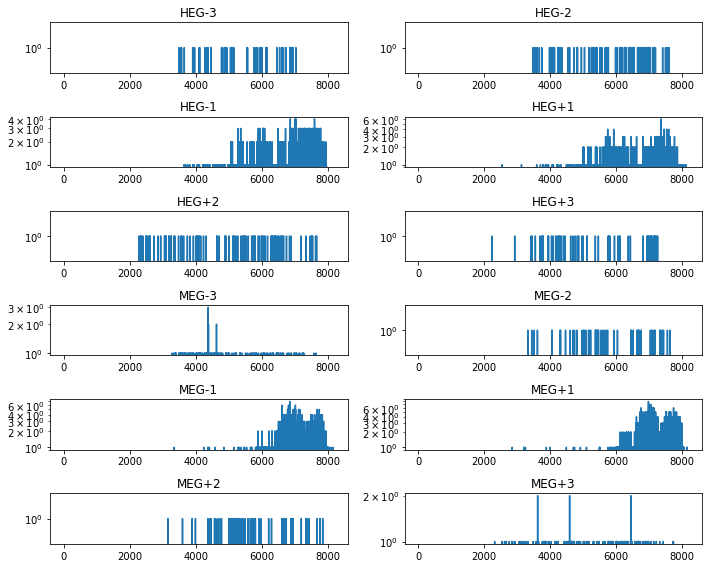

In [5]:
## Here, you just have to be familiar with the format of these spectra by reading Chandra documentation.
for i in range(len(table)):
    matplotlib.rcParams['figure.figsize'] = (10, 8)
    ax=plt.subplot(6,2,i+1)
    pha = plt.plot( table['CHANNEL'][i],table['COUNTS'][i])
    ax.set_yscale('log')
    if table['TG_PART'][i] == 1:
        instr='HEG'
    if table['TG_PART'][i] == 2:
        instr='MEG'
    if table['TG_PART'][i] == 3:
        instr='LEG'
    ax.set_title("{grating}{order:+d}".format(grating=instr, order=table['TG_M'][i]))
    plt.tight_layout()
    

Note: The 12 plots here show all the different HEG and MEG components (+/- 3, +/- 2, and +/- 1 for each grating) for the grating data, as titled. In practice, you might want to download the fits file and use a different analysis and plotting tool to create an energy spectrum plot using SHERPA or XSPEC, etc. 

You can download the file directly using this:


In [6]:
## Because urllib is annoying to make Python 2/3 compatible, just use requests:
r=requests.get(spec_tables[0][2][col], stream=True)
with open('downloads/my_spectrum.fits','wb') as f:
    f.write(r.content)

## Analyze it with PyXspec

<div>
Note that currently, we do not have a way to link the spectra to their corresponding response files.  In some cases, you can take the download URL for the spectrum and look for the response in the same directory, but this is obviously not ideal.  In other cases, it's even less obvious how to find the correct response.  A knowledge of the specific mission archive and tools is currently necessary.  For this example, we have retrieved off-line the relevant file and stored it as "my_arf.fits".  This is an issue to be addressed by the HEASARC in the future to make this process more feasible. For now, this example is a proof-of-concept only.  
</div>

In [7]:
xspec.Xset.allowPrompting = False # keeps pyxspec from hanging, waiting for a response to a prompt
##  The type II PHA files contain multiple spectra, and we tell Xspec to select with the 
##  curly bracket notation and the number starting from 1 (not zero):
with sys_pipes():
    pha = xspec.Spectrum("downloads/my_spectrum.fits{10}")
    ##  As mentioned above, this is retrieved off-line for now.
    #pha.response="tgcat/obs_19792_tgid_5277/heg_1.rmf.gz"
    #pha.response.arf="tgcat/obs_19792_tgid_5277/heg_1.arf.gz"    
    #pha.response="tgcat/obs_19792_tgid_5277/meg_1.rmf.gz"
    #pha.response.arf="tgcat/obs_19792_tgid_5277/meg_1.arf.gz"
    pha.response="aux/my_rmf.fits.gz"
    pha.response.arf="aux/my_arf.fits.gz"


1 spectrum  in use
 
Spectral Data File: downloads/my_spectrum.fits{10}  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.696e-02 +/- 5.616e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-8192
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 3.202e+04 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.
Arf successfully loaded.


In [8]:
with sys_pipes():
    m = xspec.Model("tbabs*po+ga")


Model TBabs<1>*powerlaw<2> + gaussian<3> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   3    2   powerlaw   norm                1.00000      +/-  0.0          
   4    3   gaussian   LineE      keV      6.50000      +/-  0.0          
   5    3   gaussian   Sigma      keV      0.100000     +/-  0.0          
   6    3   gaussian   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic : Chi-Squared =   1.778199e+08 using 8192 PHA bins.

Test statistic : Chi-Squared =   1.778199e+08 using 8192 PHA bins.
 Reduced chi-squared =       21722.44 for   8186 degrees of freedom 
 Null hypothesis probability =   0.000000e+00
 Current data and model not fit yet.


tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.


In [9]:
with sys_pipes():
    xspec.Fit.statMethod ="cstat"
    xspec.Fit.perform()

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic : C-Statistic =   1.855312e+06 using 8192 PHA bins and 8186 degrees of freedom.

    Source file is not Poisson


Test statistic : Chi-Squared =   1.778199e+08 using 8192 PHA bins.
 Reduced chi-squared =       21722.44 for   8186 degrees of freedom 
 Null hypothesis probability =   0.000000e+00
 Current data and model not fit yet.
                                   Parameters
C-Statistic  |beta|/N    Lvl          1:nH    2:PhoIndex        3:norm       4:LineE       5:Sigma        6:norm
2504.57      16950.9      -3      0.879406       1.47874    0.00320258       7.37281       1.35135    0.00111742
2450.51      8926.05      -4      0.738089       1.47741    0.00325654       9.62676       2.40504    0.00121040
2447.39      340.548      -2      0.636247       1.34354    0.00284924       13.6065       2.14369    0.00294379
2443.07      1251.89      -3      0.581127       

We can plot the results using, e.g., matplotlib (first example below) or Xspec's own plotting routines (second example below):

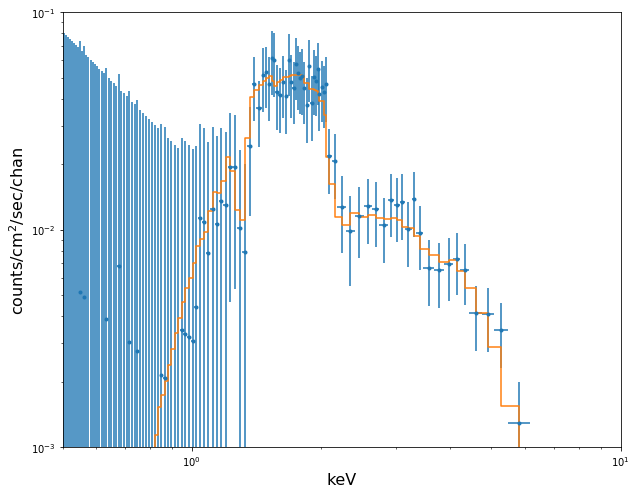

In [10]:

ax = plt.subplot(111)

from astropy.convolution import convolve, Box1DKernel
import numpy as np
plt.rcParams['figure.figsize'] = (10, 4)

with sys_pipes():
    xspec.Plot.device = "/nu"
    ## This tells xspec.Plot that you want to use energy for the x-axis; otherwise, you get channel.
    xspec.Plot.xAxis = "keV"
    ## Tell Xspec to divide out the effective area to give flux
    #xspec.Plot.area = True
    ## This tells Xspec to rebin the result, which is otherwise very noisy
    xspec.Plot.setRebin(minSig=3.0, maxBins=50)
    xspec.Plot("data")
    xVals = xspec.Plot.x()
    xValserr = xspec.Plot.xErr()
    yVals = xspec.Plot.y()
    yValserr = xspec.Plot.yErr()
    modVals = xspec.Plot.model()

plt.errorbar(xVals, yVals, yerr=yValserr, xerr=xValserr, fmt='.')

plt.step(xVals, modVals)
plt.xlabel('keV', fontsize=16)
plt.ylabel('counts/cm$^2$/sec/chan', fontsize=16)
ax.set_yscale('log')
ax.set_ylim([1e-3,1e-1])
ax.set_xlim([0.5,10])
ax.set_xscale('log')


# Chandra Spectrum of Delta Ori

In [11]:
from astropy.coordinates import SkyCoord
delori=SkyCoord.from_name("delta ori")
pos='{},{}'.format(delori.ra.deg,delori.dec.deg)

spec_tables=Spectra.query(service=services[-1],coords=pos,radius=0.1,verbose=True)

spec_tables[0]['time'].format='.4f'
spec_tables[0].show_in_notebook()

    Querying service https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&
    Got 6 results for parameters[0]


idx,obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_start_time,SSA_tmid,SSA_stop_time,SSA_duration,SSA_ra,SSA_dec,SSA_coord_obs,SSA_title,SSA_reference,SSA_datalength,SSA_datamodel,SSA_instrument,SSA_publisher,SSA_format,SSA_fov,SSA_wavelength_min,SSA_wavelength_max,SSA_bandwidth,SSA_bandpass
,,,,deg,deg,mjd,,,s,,,mjd,mjd,mjd,mjd,s,deg,deg,deg,,,,,,,,deg,meter,meter,meter,meter
0,639,archived,DELTA ORI,83.00125,-0.29917,51556.1364,ACIS-S,HETG,49680,GO,Cassinelli,52037,51556.1364,51556.43650057151,51556.735856340485,49680.0,83.00125,-0.29917,--,acisf00639N004_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao01/cat2/639/primary/acisf00639N004_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
1,7416,archived,delta Ori HD 36486,83.00167,-0.29908,54413.4270,HRC-S,LETG,97080,GO,Raassen,54783,54413.427,54413.99748095434,54414.56715379722,97080.0,83.00167,-0.29908,--,hrcf07416N003_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao08/cat2/7416/primary/hrcf07416N003_pha2.fits.gz,2.0,Spectrum-1.0,HRC-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
2,14567,archived,Delta Ori,83.00167,-0.29908,56280.7037,ACIS-S,HETG,116500,GO,Corcoran,56647,56280.7037,56281.38982472211,56282.07517784063,116500.0,83.00167,-0.29908,--,acisf14567N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14567/primary/acisf14567N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
3,14568,archived,Delta Ori,83.00167,-0.29908,56288.1612,ACIS-S,HETG,123600,GO,Corcoran,56655,56288.1612,56288.89025076302,56289.61850203206,123600.0,83.00167,-0.29908,--,acisf14568N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14568/primary/acisf14568N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
4,14569,archived,Delta Ori,83.00167,-0.29908,56283.2540,ACIS-S,HETG,120850,GO,Corcoran,56650,56283.254,56283.96498017049,56284.67520199699,120850.0,83.00167,-0.29908,--,acisf14569N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14569/primary/acisf14569N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
5,14570,archived,Delta Ori,83.00167,-0.29908,56285.5508,ACIS-S,HETG,124100,GO,Corcoran,56652,56285.5508,56286.28389746857,56287.016223824656,124100.0,83.00167,-0.29908,--,acisf14570N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14570/primary/acisf14570N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.8110350040397626,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09


In [12]:
hdu_list=fits.open(spec_tables[0][5][col]) 
#hdu_list.info()
table = Table(hdu_list[1].data)
table.show_in_notebook()

idx,SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
0,1,-3,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
1,2,-2,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
2,3,-1,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
3,4,1,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
4,5,2,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
5,6,3,1,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
6,7,-3,2,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,13.985000000001373 .. 0.3333333333333333,13.98666666666804 .. 0.33499999999999996
7,8,-2,2,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,20.977500000001505 .. 0.5,20.980000000001507 .. 0.5025
8,9,-1,2,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,41.95500000000301 .. 1.0,41.960000000003014 .. 1.005
9,10,1,2,1,4113.775,4083.7346,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,41.95500000000301 .. 1.0,41.960000000003014 .. 1.005


In [13]:
## Because urllib is annoying to make Python 2/3 compatible, just use requests:
r=requests.get(spec_tables[0][5][col], stream=True)
with open('delori_spectrum.fits','wb') as f:
    f.write(r.content)

In [14]:
with sys_pipes():
    xspec.AllData.clear()
    xspec.AllData += "delori_spectrum.fits{10}"
    pha = xspec.AllData(1)
    pha.response="aux/meg_1.rmf.gz"
    pha.response.arf="aux/meg_1.arf.gz"


1 spectrum  in use
 
Spectral Data File: delori_spectrum.fits{10}  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.140e-02 +/- 1.529e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-8192
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 1.225e+05 sec
 Using fit statistic: cstat
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

Fit statistic : C-Statistic =       59448.77 using 8192 PHA bins and 8186 degrees of freedom.

    Source file is not Poisson


Test statistic : Chi-Squared =   3.524758e+06 using 8192 PHA bins.
 Reduced chi-squared =       430.5837 for   8186 degrees of freedom 
 Null hypothesis probability =   0.000000e+00
 Current data and model not fit yet.
Arf successfully loaded.

Fit statistic : C-Statistic =       22688.44 using 8192 PHA bins and 8186 degrees of freedom.

    Source file is not 

In [ ]:
with sys_pipes():
    m = xspec.Model("TBabs*apec + TBabs*apec")
    m.apec.kT = [.1,.01,.05,.05,1,1]
    m.apec.norm = 5e-4
    m.apec_4.kT = [1,.01,.7,.7,4,4]
    m.apec_4.norm = 1e-3
    m.TBabs.nH = [.01,0.01,0.0,0.0,.4,.4]
    m.TBabs_3.nH = [.01,0.01,0.0,0.0,.4,.4]



In [ ]:
with sys_pipes():
    pha.show()
    m.show()

In [ ]:
with sys_pipes():
    xspec.Plot.device = "/nu"
    xspec.Plot.xAxis = "Angstrom"
    xspec.Plot.setRebin(minSig=3.0, maxBins=10)
    xspec.Plot("data")
    xVals = xspec.Plot.x()
    xValserr = xspec.Plot.xErr()
    yVals = xspec.Plot.y()
    yValserr = xspec.Plot.yErr()
    modVals = xspec.Plot.model()

plt.step(xVals, yVals, label='Data')

plt.step(xVals, modVals, label="Model")
plt.xlabel('Angstrom', fontsize=16)
plt.ylabel('counts/cm$^2$/sec/chan', fontsize=16)
plt.legend()
plt.yscale('linear')
plt.xlim([0.5,20])
plt.xscale('linear')



In [ ]:
with sys_pipes():
    xspec.Fit.statMethod ="cstat"
    xspec.Fit.perform()

In [ ]:

ax = plt.subplot(111)
plt.rcParams['figure.figsize'] = (10, 4)

with sys_pipes():
    xspec.Plot.device = "/nu"
    xspec.Plot.xAxis = "Angstrom"
    xspec.Plot.setRebin(minSig=3.0, maxBins=10)
    xspec.Plot("data")
    xVals = xspec.Plot.x()
    xValserr = xspec.Plot.xErr()
    yVals = xspec.Plot.y()
    yValserr = xspec.Plot.yErr()
    modVals = xspec.Plot.model()

plt.step(xVals, yVals)

plt.step(xVals, modVals)
plt.xlabel('Angstrom', fontsize=16)
plt.ylabel('counts/cm$^2$/sec/chan', fontsize=16)
ax.set_yscale('linear')
#ax.set_ylim([1e-3,1e-1])
ax.set_xlim([11,15])
ax.set_xscale('linear')
